# Compare Twitter and Reddit Populations

## Analyis of Shared Text

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform in terms of the **text** they share.

The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [28]:
%matplotlib inline

In [29]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [30]:
import sklearn.preprocessing
import sklearn.metrics

In [31]:
sample_count = 1000
bootstrap_count = 5000

In [32]:
twitter_links_df_rand = pd.read_csv("twitter_random_sample_user_means.csv")
twitter_links_df_poli = pd.read_csv("twitter_political_sample_user_means.csv")
twitter_links_df_ira = pd.read_csv("twitter_ira_sample_user_means.csv")

In [33]:
reddit_links_df_rand = pd.read_csv("reddit_random_sample_user_means.csv")
reddit_links_df_poli = pd.read_csv("reddit_political_sample_user_means.csv")
reddit_links_df_ira = pd.read_csv("reddit_ira_sample_user_means.csv")

In [34]:
def df_to_matrix(local_df):
    
    users = local_df['0']
    mat = local_df[[str(x) for x in range(1,local_df.shape[1])]].to_dense()
    
    return (users, mat)

In [35]:
# similarity_function = sklearn.metrics.pairwise.cosine_similarity
similarity_function = sklearn.metrics.pairwise.cosine_distances
# similarity_function = sklearn.metrics.pairwise.euclidean_distances

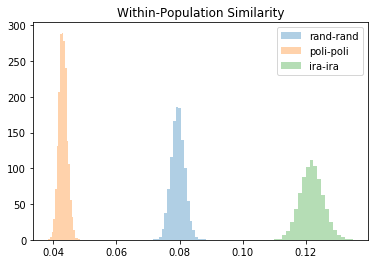

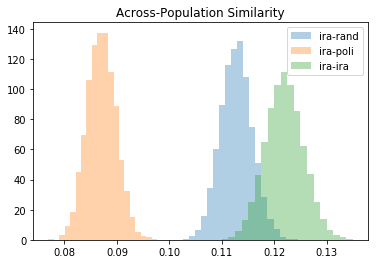

In [36]:
u_rand, twitter_user_links_mat_rand = df_to_matrix(twitter_links_df_rand)
u_poli, twitter_user_links_mat_poli = df_to_matrix(twitter_links_df_poli)
u_ira, twitter_user_links_mat_ira = df_to_matrix(twitter_links_df_ira)

# t2t_rand_rand_dist = sklearn.metrics.pairwise.euclidean_distances(
#     twitter_user_links_mat_rand, twitter_user_links_mat_rand)


# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = similarity_function(
    twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = similarity_function(
    twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = similarity_function(
    twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = similarity_function(
    twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = similarity_function(
    twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_rand_poli_sim = similarity_function(
    twitter_user_links_mat_rand, twitter_user_links_mat_poli)

# # Collapse similarities down to get the mean similarity for each user on the left to all users on the right
# #. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
# #. self-similarity effect
# t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
# t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
# t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
# t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
# t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
# t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
# t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

t2t_rand_rand_sim_flat = t2t_rand_rand_sim.flatten()
t2t_poli_poli_sim_flat = t2t_poli_poli_sim.flatten()
t2t_ira_ira_sim_flat = t2t_ira_ira_sim.flatten()
t2t_ira_rand_sim_flat = t2t_ira_rand_sim.flatten()
t2t_ira_poli_sim_flat = t2t_ira_poli_sim.flatten()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_rand_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
t2t_poli_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_poli_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
t2t_ira_ira_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_ira_ira_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_ira_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
t2t_ira_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_ira_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [37]:
print("Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), np.array(t2t_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), np.array(t2t_ira_ira_sim_avg_bootstrap).var())


Random: 0.07946397512353522 4.479417736741423e-06
Political: 0.04303884887347692 1.7875956400997122e-06
Russian IRA: 0.12189080902607438 1.3163992955769394e-05


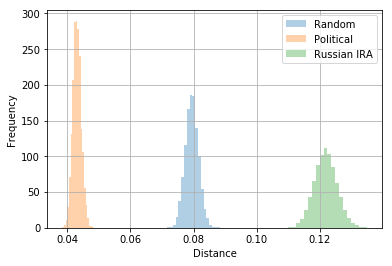

In [38]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

# plt.title("Twitter, Within-Group Similarity")

plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.legend()
plt.grid()

plt.savefig("within_group_general_text_twitter.pdf", format="pdf")
plt.show()

In [39]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 1202020.7067219962
p-value for Welch's t-Test between Rand and IRA: 0.0 -714.1524335507638
p-value for Welch's t-Test between Poli and IRA: 0.0 -1441.8178333067688


In [40]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.07946397512353522 4.479417736741423e-06
Russian IRA-Random: 0.11278970199224536 9.167385322149551e-06
Russian IRA-Political: 0.0870405340425707 7.650368863052573e-06


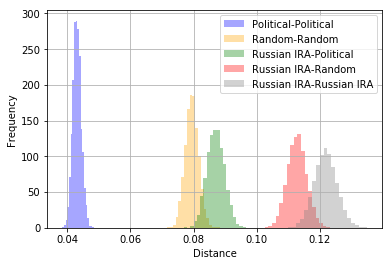

In [41]:
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political-Political", color="blue")
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random", color="orange")

plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political", color="green")

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random", color="red")

plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Russian IRA", color="gray")

# plt.title("Within-Twitter Similarity")

plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.legend()
plt.grid()

plt.savefig("across_group_general_text_twitter.pdf", format="pdf")
plt.show()

In [42]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 214894.93623828416
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 443.9364125040683


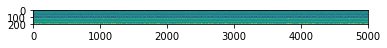

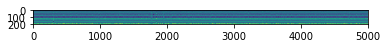

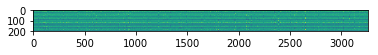

In [43]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

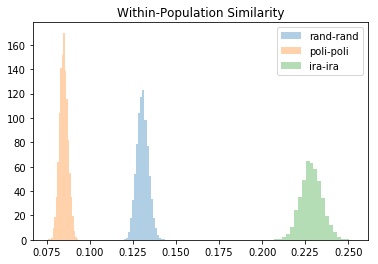

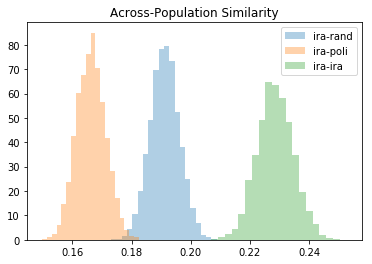

In [44]:
u_rand, reddit_user_links_mat_rand = df_to_matrix(reddit_links_df_rand)
u_poli, reddit_user_links_mat_poli = df_to_matrix(reddit_links_df_poli)
u_ira, reddit_user_links_mat_ira = df_to_matrix(reddit_links_df_ira)

# r2r_rand_rand_dist = sklearn.metrics.pairwise.euclidean_distances(
#     reddit_user_links_mat_rand, reddit_user_links_mat_rand)


# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = similarity_function(
    reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = similarity_function(
    reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = similarity_function(
    reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = similarity_function(
    reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = similarity_function(
    reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_rand_poli_sim = similarity_function(
    reddit_user_links_mat_rand, reddit_user_links_mat_poli)

# # Collapse similarities down to get the mean similarity for each user on the left to all users on the right
# #. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
# #. self-similarity effect
# r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
# r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
# r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
# r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
# r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
# r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
# r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

r2r_rand_rand_sim_flat = r2r_rand_rand_sim.flatten()
r2r_poli_poli_sim_flat = r2r_poli_poli_sim.flatten()
r2r_ira_ira_sim_flat = r2r_ira_ira_sim.flatten()
r2r_ira_rand_sim_flat = r2r_ira_rand_sim.flatten()
r2r_ira_poli_sim_flat = r2r_ira_poli_sim.flatten()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_rand_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2r_poli_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_poli_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2r_ira_ira_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_ira_ira_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_ira_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2r_ira_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_ira_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [45]:
print("Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), np.array(r2r_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), np.array(r2r_ira_ira_sim_avg_bootstrap).var())


Random: 0.1305101569173625 1.1124677886264267e-05
Political: 0.08484649499967713 5.985187824895688e-06
Russian IRA: 0.22858136159589343 3.761554146321341e-05


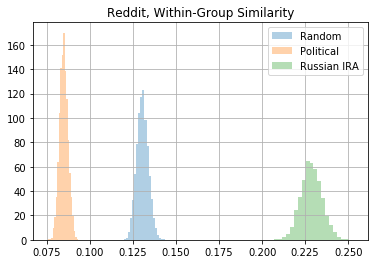

In [46]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

plt.title("Reddit, Within-Group Similarity")
plt.legend()
plt.grid()
plt.show()

In [47]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 1478123.790406319
p-value for Welch's t-Test between Rand and IRA: 0.0 -993.2060098437321
p-value for Welch's t-Test between Poli and IRA: 0.0 -1539.0645033776311


In [48]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())



Random-Random: 0.1305101569173625 1.1124677886264267e-05
Russian IRA-Random: 0.191235818777498 2.4339612846062714e-05
Russian IRA-Political: 0.16630172807067434 2.3807838888343303e-05


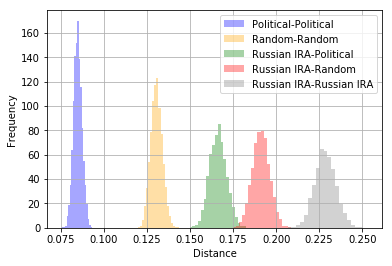

In [63]:
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political-Political", color="blue")
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random", color="orange")

plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political", color="green")

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random", color="red")

plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Russian IRA", color="gray")

# plt.title("Within-Reddit Similarity")

plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.legend()
plt.grid()

plt.savefig("across_group_general_text_reddit.pdf", format="pdf")
plt.show()

In [64]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 235744.5826069321
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 254.06711154966882


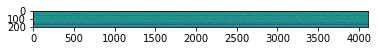

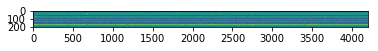

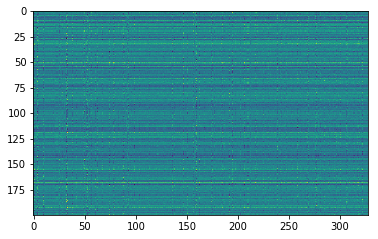

In [65]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

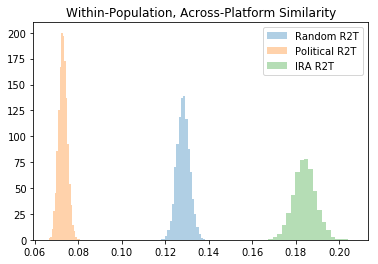

In [66]:
r2t_rand_sim = similarity_function(
    reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = similarity_function(
    reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = similarity_function(
    reddit_user_links_mat_ira, twitter_user_links_mat_ira)

r2t_rand_sim_flat = r2t_rand_sim.flatten()
r2t_poli_sim_flat = r2t_poli_sim.flatten()
r2t_ira_sim_flat = r2t_ira_sim.flatten()

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2t_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2t_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2t_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2t_ira_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2t_ira_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [67]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())



Random-R2T: 0.1282641268562713 8.333061150051443e-06
Political-R2T: 0.07305782251413723 4.027496262364702e-06
Russian IRA-R2T: 0.1840471962560689 2.6022766064924074e-05


In [68]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.1840471962560689 2.6022766064924074e-05
Russian IRA-RRandom: 0.191235818777498 2.4339612846062714e-05
Russian IRA-RPoli: 0.16630172807067434 2.3807838888343303e-05


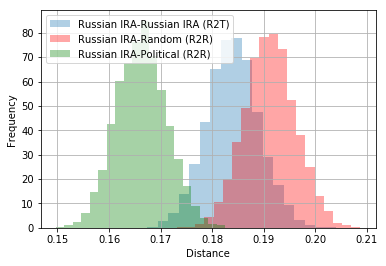

In [69]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Russian IRA (R2T)")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random (R2R)", color="red")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political (R2R)", color="green")

# plt.title("Reddit-to-Twitter Similarity")

plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.legend()
plt.grid()

plt.savefig("across_platform_general_text_reddit.pdf", format="pdf")
plt.show()

In [70]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 33304.78142726421
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -71.61996912299098
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 177.73827076526578


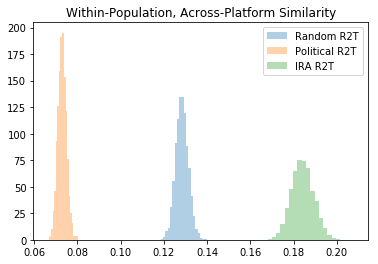

In [71]:
t2r_rand_sim = similarity_function(
    twitter_user_links_mat_rand, reddit_user_links_mat_rand)
t2r_poli_sim = similarity_function(
    twitter_user_links_mat_poli, reddit_user_links_mat_poli)
t2r_ira_sim = similarity_function(
    twitter_user_links_mat_ira, reddit_user_links_mat_ira)

t2r_rand_sim_flat = t2r_rand_sim.flatten()
t2r_poli_sim_flat = t2r_poli_sim.flatten()
t2r_ira_sim_flat = t2r_ira_sim.flatten()

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2r_rand_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
t2r_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2r_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
t2r_ira_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2r_ira_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



In [72]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Russian IRA-T2R: 0.18415877975460093 2.6544751291737666e-05
Russian IRA-TRandom: 0.11278970199224536 9.167385322149551e-06
Russian IRA-TPoli: 0.0870405340425707 7.650368863052573e-06


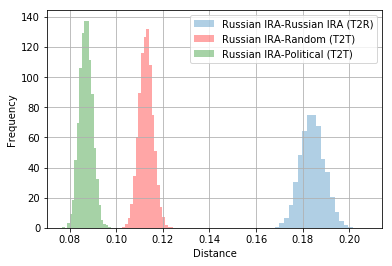

In [74]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Russian IRA (T2R)")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random (T2T)", color="red")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political (T2T)", color="green")

# plt.title("Twitter-to-Reddit Similarity")

plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.legend()
plt.grid()

plt.savefig("across_platform_general_text_twitter.pdf", format="pdf")
plt.show()

In [60]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 861322.5561040734
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 836.0822206884754
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 1162.1657213413823


In [61]:
## Full Cross-Comparison

### Other comparisons

t2t_rand_poli_sim_flat = t2t_rand_poli_sim.flatten()
r2r_rand_poli_sim_flat = r2r_rand_poli_sim.flatten()

t2t_rand_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        t2t_rand_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]
r2r_rand_poli_sim_avg_bootstrap = [
    sklearn.utils.resample(
        r2r_rand_poli_sim_flat, replace=True, n_samples=sample_count
    ).mean() 
    for i in range(bootstrap_count)
]



In [62]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)


	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: 0.1305101569173625 1.1124677886264267e-05 0.11164366912349155 8.86744305461631e-06 0.191235818777498 2.4339612846062714e-05 0.1284301281786208 8.643174966363312e-06
Political: 0.11164366912349155 8.86744305461631e-06 0.08484649499967713 5.985187824895688e-06 0.16630172807067434 2.3807838888343303e-05 0.07304981627798293 4.0127662620480705e-06
IRA: 0.191235818777498 2.4339612846062714e-05 0.16630172807067434 2.3807838888343303e-05 0.22858136159589343 3.761554146321341e-05 0.1840241857417226 2.607649064339682e-05
Twitter
Random: 0.07946397512353522 4.479417736741423e-06 0.07390394754585634 3.880787286039844e-06 0.11278970199224536 9.167385322149551e-06 0.12831291166591186 8.559033856954713e-06
Political: 0.07390394754585634 3.880787286039844e-06 0.04303884887347692 1.7875956400997122e-06 0.0870405340425707 7.650368863052573e-06 0.07310446287646827 3.974809908760075e-06
IRA: 0.11278970199224

### Compare Identically Named Users

In [36]:
reddit_troll_names = pd.read_csv("../data/reddit_troll_accounts_20190206.csv")
twitter_troll_names = pd.read_csv("../data/twitter_russian_troll_accounts.csv")

FileNotFoundError: File b'../data/reddit_troll_accounts_20190206.csv' does not exist

In [ ]:
cross_platform_users = set(twitter_troll_names["handle"].apply(str.lower))\
    .intersection(set(reddit_troll_names["username"].apply(str.lower)))

print("User count with the same ID:", len(cross_platform_users))
for u in cross_platform_users:
    print(u)

In [ ]:
deanon_df = pd.read_csv("../data/deanon_v2.csv")

In [ ]:
deanon_map = {row["screen_name"].lower():row["userid"] for _, row in deanon_df.iterrows()}

In [ ]:
for u in cross_platform_users:
    print(u, deanon_map.get(u))
    

In [ ]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    print(u, deanon_map.get(u))
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)
    print("\t", "Twitter TLDs:", len(local_twitter_tld), "Reddit TLDs:", len(local_reddit_tld))
    print("\t", "TLDs in Common:", len(common_tlds))

    if ( len(common_tlds) == 0 ):
        continue
        
    local_sim = sklearn.metrics.pairwise.cosine_similarity(
        links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
        links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
    print("\t", "Local Similarity:", local_sim)

In [ ]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)

    sim = 0.0
    if ( len(common_tlds) > 0 ):
        local_sim = sklearn.metrics.pairwise.cosine_similarity(
            links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
            links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
        sim = local_sim[0]
        
    print("%s & %d & %d & %d & %f \\\\" % (u, len(local_reddit_tld), len(local_twitter_tld), len(common_tlds), sim))
    